In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
from sklearn.preprocessing import StandardScaler, normalize
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [3]:
train = pd.read_csv('/content/train.csv')
train.shape

(5380, 767)

In [4]:
test = pd.read_csv('/content/test.csv')
test.shape

(4403, 766)

In [5]:
num_missing = train.isna().sum().sum()
print(num_missing)

num_cols_missing = (train.isna().any()).sum()
print(num_cols_missing)

num_rows_missing = (train.isna().any(axis=1)).sum()
print(num_rows_missing)

29911
473
2523


In [6]:
y_train = train['y']
X_train = train.drop(['y', 'id'], axis = 1)

In [7]:
col_id = test['id']
X_test = test.drop(['id'], axis = 1)

In [8]:
imputer = KNNImputer(n_neighbors = 5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = X_test.columns)

In [9]:
selection0 = VarianceThreshold(threshold=0)
selection0.fit(X_train)
X_train = selection0.transform(X_train)
X_train.shape

(5380, 754)

In [10]:
X_test = selection0.transform(X_test)
X_test.shape

(4403, 754)

In [11]:
selection_low = VarianceThreshold(threshold=0.01)
selection_low.fit(X_train)
X_train = pd.DataFrame(selection_low.transform(X_train))
X_train.shape

(5380, 707)

In [12]:
X_test = pd.DataFrame(selection_low.transform(X_test))
X_test.shape

(4403, 707)

In [13]:
correlations = []
p_values = []

for feature in X_train.columns:
    correlation, p_value = spearmanr(X_train[feature], y_train)
    correlations.append(correlation)
    p_values.append(p_value)

In [14]:
sorted_indices = sorted(range(len(correlations)), key=lambda i: abs(correlations[i]), reverse=True)
selected_features = [X_train.columns[i] for i in sorted_indices[:50]]

In [15]:
X_train1 = X_train[selected_features]
X_test1 = X_test[selected_features]

>10 10.226 (0.396)
>15 10.243 (0.382)
>20 10.240 (0.351)
>25 10.298 (0.324)
>30 10.315 (0.350)


Text(0.5, 0, 'Number of trees')

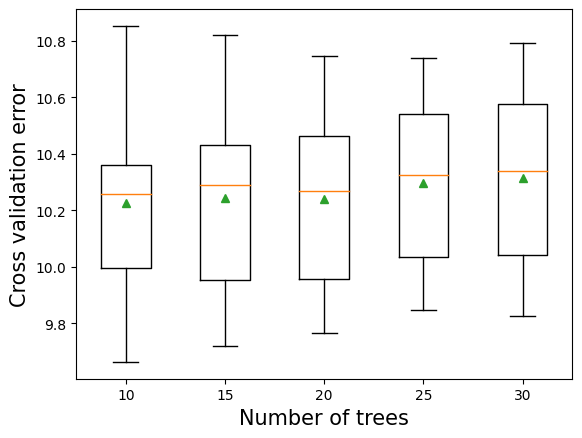

In [32]:
def get_models():
    models = dict()
    for n in [10, 15, 20, 25, 30]:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train1, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>5 10.222 (1.076)
>7 10.383 (0.987)
>9 10.469 (1.015)
>11 10.563 (1.046)
>13 10.527 (1.155)
>15 10.717 (1.087)
>17 10.656 (1.210)


Text(0.5, 0, 'Depth of each tree')

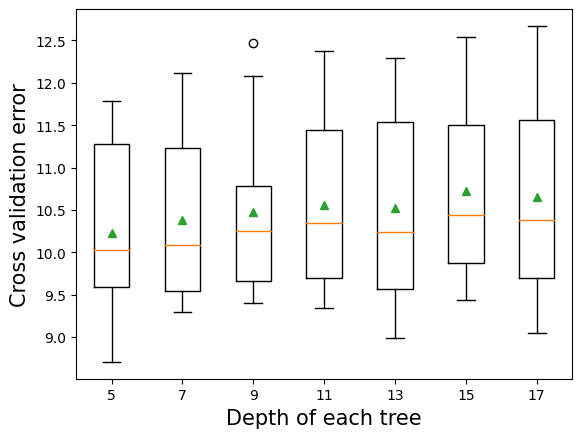

In [31]:
def get_models():
    models = dict()
    for i in [5, 7, 9, 11, 13, 15, 17]:
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train1, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0100 10.8 (1.5)
>0.0200 10.0 (1.3)
>0.0300 9.8 (1.2)
>0.0500 9.8 (1.1)


Text(0.5, 0, 'Learning rate')

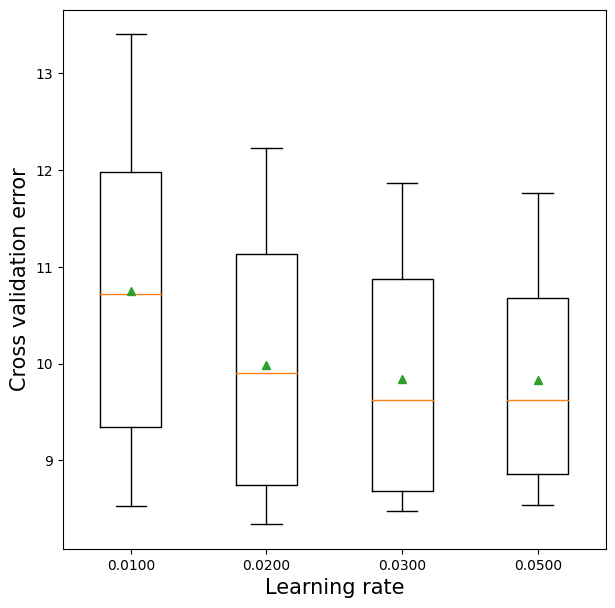

In [25]:
def get_models():
    models = dict()
    for i in [0.01, 0.02, 0.03, 0.04, 0.05]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train1, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.3000 10.6 (1.0)
>0.3500 10.3 (1.0)
>0.4000 10.4 (1.1)
>0.4500 10.3 (1.0)
>0.5000 10.3 (1.0)


Text(0.5, 0, 'reg_lambda')

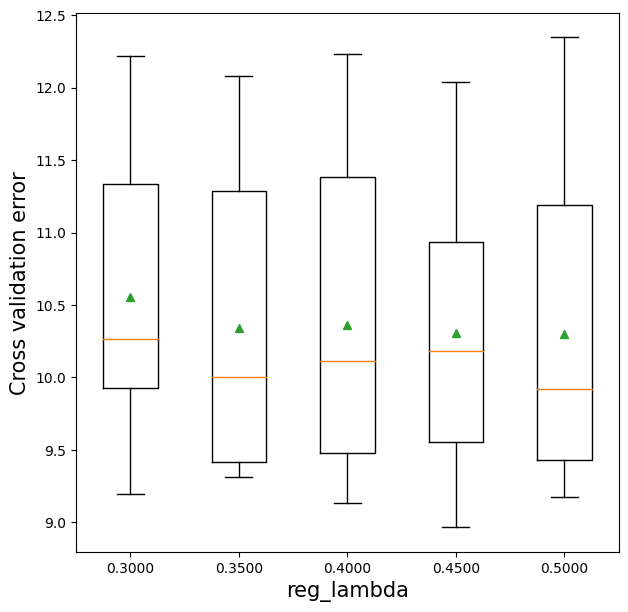

In [29]:
def get_models():
    models = dict()
    for i in [0.3, 0.35, 0.4, 0.45, 0.5]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train1, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [33]:
param_grid = {'n_estimators':[16, 18, 20],
              'max_depth': [9, 10, 11, 12, 13],
              'learning_rate': [0.016, 0.018, 0.020, 0.022],
              'reg_lambda':[0.35, 0.40, 0.45]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train1, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Optimal parameter values = {'learning_rate': 0.022, 'max_depth': 9, 'n_estimators': 20, 'reg_lambda': 0.35}
Optimal cross validation R-squared =  -0.016989833610167194


In [34]:
model_XG = xgb.XGBRegressor(n_estimators=20, max_depth=9, learning_rate = 0.022, reg_lambda=0.35, random_state=1).fit(X_train1, y_train)

In [35]:
warnings.filterwarnings("ignore")

>50 9.882 (1.085)
>100 9.814 (1.072)
>150 9.790 (1.081)
>200 9.772 (1.074)


Text(0.5, 0, 'n_estimators')

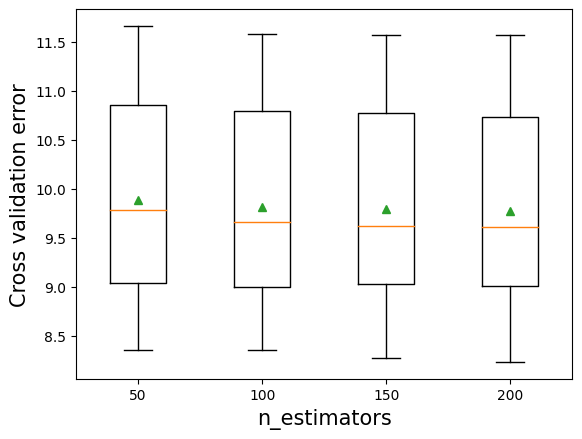

In [40]:
def get_models():
    models = dict()
    for i in [50, 100, 150, 200]:
        models[str(i)] = RandomForestRegressor(random_state=1, n_estimators=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train1, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('n_estimators',fontsize=15)

>10 9.883 (1.064)
>15 9.873 (1.055)
>20 9.862 (1.067)
>25 9.856 (1.098)


Text(0.5, 0, 'n_estimators')

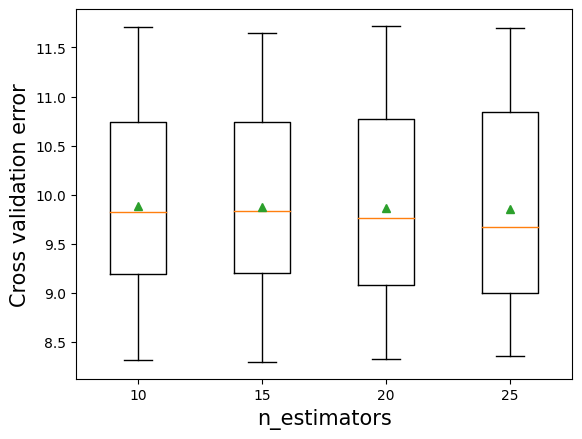

In [43]:
def get_models():
    models = dict()
    for i in [10, 15, 20, 25]:
        models[str(i)] = RandomForestRegressor(random_state=1, max_features=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train1, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('n_estimators',fontsize=15)

In [44]:
params = {'n_estimators': [80, 90, 100],
          'max_features': [18, 20, 22]}
param_list=list(it.product(*(params[Name] for Name in params)))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_features=pr[1],n_jobs=-1).fit(X_train1, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (100, 20)
Best score (R-squared) =  0.29663264377396925


In [45]:
model_RF = RandomForestRegressor(n_estimators=100, max_features=20, random_state=1, n_jobs=-1).fit(X_train1, y_train)

In [46]:
model_ENET = ElasticNetCV(l1_ratio=0.5, alphas=[0.1, 0.25, 0.5, 0.75, 1])
model_ENET.fit(X_train1, y_train)

ElasticNetCV(alphas=[0.1, 0.25, 0.5, 0.75, 1])

In [ ]:
optimal_kernel = grid_search.best_estimator_.kernel
optimal_C = grid_search.best_estimator_.C
optimal_degree = grid_search.best_estimator_.degree
optimal_gamma = grid_search.best_estimator_.gamma

model_SVM = SVR(kernel=optimal_kernel, C=optimal_C, degree=optimal_degree, gamma=optimal_gamma).fit(X_train1, y_train)

In [75]:
model_ensemble= StackingRegressor(estimators = [('XG', model_XG),
                                                ('RF', model_RF),
                                                ('ENET', model_ENET),
                                                ('SVM', model_SVM)],
                      final_estimator = LassoCV(),
                      cv = KFold(n_splits = 5, shuffle = True, random_state=1))
model_ensemble.fit(X_train1, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                  estimators=[('XG',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_ty...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1, ...)),
                              ('RF',
                               RandomForestRegressor(max_features=20, n_jobs=-1,
                                                     random_state=1)),
                              ('ENET',
                               ElasticNetCV(alphas=[0.1, 0.25, 0.5, 0.75, 1]))],
                  final_estimator=LassoCV())

In [76]:
model_ensemble.final_estimator_.coef_

array([0.27368996, 0.54359173, 0.45188472])

In [73]:
pred = model_ensemble.predict(X_test1)

pred_v29 = pd.DataFrame(index=range(X_test1.shape[0]), columns=range(2))
pred_v29.columns = ['id', 'y']
pred_v29['id'] = col_id
pred_v29['y'] = pred
pred_v29

,id,y
0,5380,6.983625
1,5381,4.695047
2,5382,2.447904
3,5383,6.105500
4,5384,10.077918
...,...,...
4398,9778,4.834957
4399,9779,6.639914
4400,9780,8.922244
4401,9781,10.565804


In [74]:
pred_v29.to_csv('pred_v29.csv', index=True)